<a href="https://colab.research.google.com/github/pedroblossbraga/OCR_CV/blob/main/Python_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pdf2image
!apt-get install poppler-utils 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 174 kB of archives.
After this operation, 754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.1 [174 kB]
Fetched 174 kB in 0s (536 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 128276 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.86.1-0ubuntu1.1_amd64.deb ...
Unpacking poppler-utils (0.86.1-0ubuntu1.1) ...
Setting up poppler-utils (0.86.1-0ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
import os
pdf_file = list(filter(
    lambda x: '.pdf' in x, os.listdir()
))[0]
pdf_file

'PedroBloessBraga_CV-5.pdf'

In [ ]:
from pdf2image import convert_from_path

pages = convert_from_path(pdf_file, 350)

i = 1
for page in pages:
    image_name = "Page_" + str(i) + ".jpg"  
    page.save(image_name, "JPEG")
    i = i+1   

list(filter(
        lambda x: '.jpg' in x, os.listdir()
    ))

['Page_2.jpg', 'Page_1.jpg']

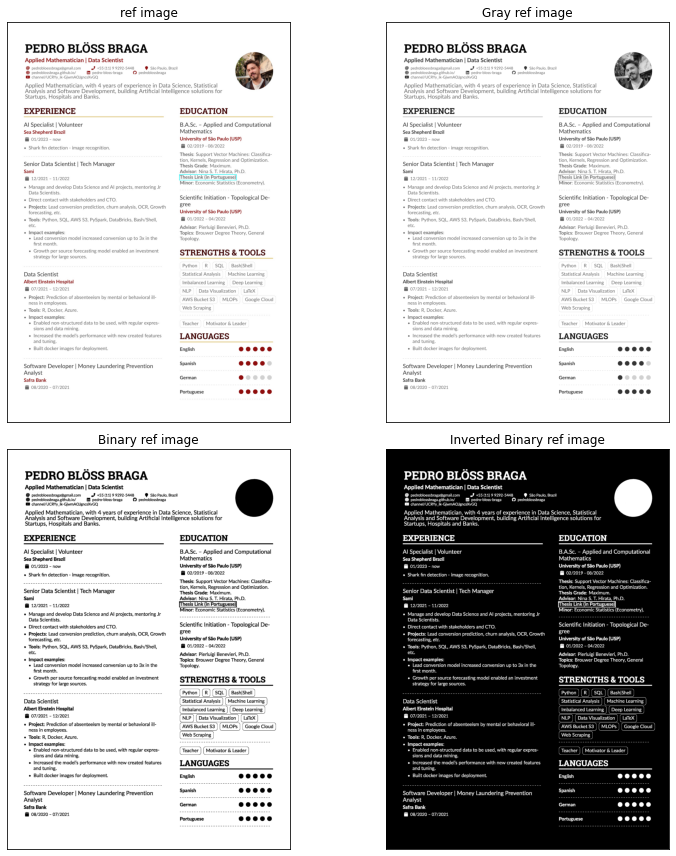

In [ ]:
import cv2
import matplotlib.pyplot as plt


def display_img_gray_bin_invbin(ref_image_path,
                                figsize = (12,12)):
  ref_img = cv2.imread(ref_image_path)
  ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

  # gray
  gray_ref_img = cv2.cvtColor(ref_img, cv2.COLOR_RGB2GRAY)

  # binary
  bin_gray_ref_img = cv2.threshold(gray_ref_img, 
                                  245,
                                  255,
                                  cv2.THRESH_BINARY)
  # inverted binary
  inv_bin_gray_ref = ~bin_gray_ref_img[1]

  plt.figure(figsize = figsize)
  plt.subplot(2,2,1)
  plt.title('ref image')
  plt.imshow(ref_img)
  plt.xticks([])
  plt.yticks([])

  plt.subplot(2,2,2)
  plt.imshow(gray_ref_img, cmap = 'gray')
  plt.title('Gray ref image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(2,2,3)
  plt.imshow(bin_gray_ref_img[1], cmap = 'gray')
  plt.title('Binary ref image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(2,2,4)
  plt.imshow(inv_bin_gray_ref, cmap = 'gray')
  plt.title('Inverted Binary ref image')
  plt.xticks([])
  plt.yticks([])

  plt.tight_layout()
  plt.show()

display_img_gray_bin_invbin(
    ref_image_path = list(filter(
                      lambda x: '.jpg' in x, os.listdir()
                  ))[1]
)

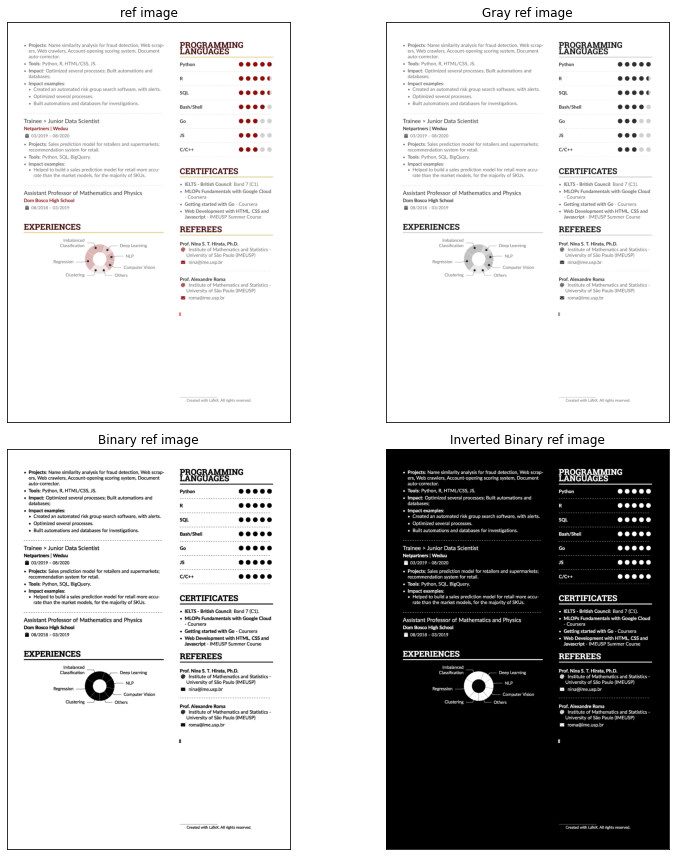

In [ ]:
display_img_gray_bin_invbin(
    ref_image_path = list(filter(
                      lambda x: '.jpg' in x, os.listdir()
                  ))[0]
)

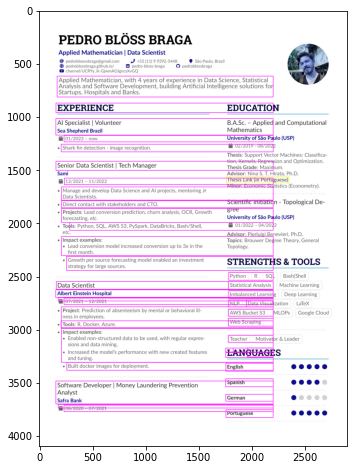

In [ ]:
from PIL import Image

def mark_region(image_path):
    
    im = cv2.imread(image_path)

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)

        if y >= 600 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
                line_items_coordinates.append([(x,y), (2200, y+h)])

        if y >= 2400 and x<= 2000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])


    return image, line_items_coordinates

image, line_items_coordinates = mark_region(
    image_path = list(filter(
                          lambda x: '.jpg' in x, os.listdir()
                      ))[1]
)

plt.figure(figsize = (12,8))
plt.imshow(image)
plt.show()

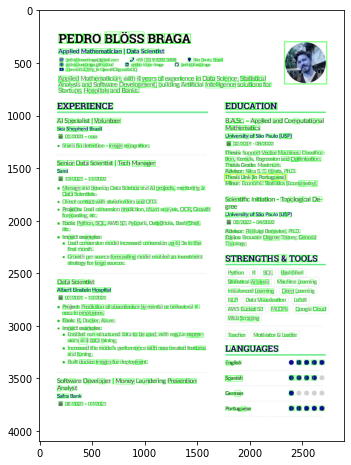

In [ ]:
import numpy as np

def mark_regions(img):
  mask = np.zeros(img.shape, dtype=np.uint8)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  # Filter for ROI using contour area and aspect ratio
  countour = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  countour = countour[0] if len(countour) == 2 else countour[1]
  for c in countour:
      area = cv2.contourArea(c)
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.05 * peri, True)
      x,y,w,h = cv2.boundingRect(approx)
      aspect_ratio = w / float(h)
      if area > 2000 and aspect_ratio > .5:
          mask[y:y+h, x:x+w] = image[y:y+h, x:x+w]

  h, w, c = img.shape
  boxes = pytesseract.image_to_boxes(img) 
  for b in boxes.splitlines():
      b = b.split(' ')
      img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

  d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
  n_boxes = len(d['text'])
  for i in range(n_boxes):
      if int(d['conf'][i]) > 60:
          (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
          img2 = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

  plt.figure(figsize=(12,8))
  plt.subplot(1,2,2)
  plt.imshow(img2)
  plt.show()

image_path = list(filter(
                          lambda x: '.jpg' in x, os.listdir()
                      ))[1]
mark_regions(
    img = cv2.imread(image_path)
)

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (4,369 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [ ]:
import pytesseract
image_path_in_colab = list(filter(
                          lambda x: '.jpg' in x, os.listdir()
                      ))[1]

extracted_text = pytesseract.image_to_string(Image.open(image_path_in_colab))
print(extracted_text)

PEDRO BLOSS BRAGA

Applied Mathematician | Data Scientist

oJ +55 (11) 9 9292-5448
#} pedroblossbraga.github.io/ ff pedro-bloss-braga © pedroblossbraga
@ channel/UCRYy_ik-GjwmAOJgncsXvGQ

@ pedrobloessbraga@gmail.com

Applied Mathematician, with 4 years of experience in Data Science, Statistical

@ S30 Paulo, Brazil

 

Analysis and Software Development, building Artificial Intelligence solutions for

Startups, Hospitals and Banks.

EXPERIENCE

Al Specialist | Volunteer
Sea Shepherd Brazil
ms 01/2023 - now

e Shark fin detection - image recognition.

Senior Data Scientist | Tech Manager

Sami

mi 12/2021 - 11/2022

e Manage and develop Data Science and Al projects, mentoring Jr
Data Scientists.

e Direct contact with stakeholders and CTO.

e Projects: Lead conversion prediction, churn analysis, OCR, Growth
forecasting, etc.

e Tools: Python, SQL, AWS S3, PySpark, DataBricks, Bash/Shell,
etc.

e Impact examples:
e Lead conversion model increased conversion up to 3x in the
first month.



In [ ]:
import re
def find_email(text):
  p = re.compile(r'[a-z]+@[a-z]+.com')
  return p.findall(text)

def find_phone_number(text):
  p = re.compile(r'\+[0-9]{2}\s\([0-9]{2}\)\s[0-9]\s[0-9]{4}[\s|\-][0-9]{4}')
  return p.findall(text)

def find_programming_languages(text,
                               prog_langs = ['Python', 
                                             'javascript', 
                                             'R', 'sql', 
                                             'C++', 'Shell']
                               ):
  return list(map(
      lambda lang: set(re.compile(r'{}'.format(
                                        lang.lower().replace('++', r'\+\+'))
                                    ).findall(text.lower())),
      prog_langs
  ))

for f in [find_email, 
          find_phone_number,
          find_programming_languages]:
  print(f(extracted_text))

['pedrobloessbraga@gmail.com']
['+55 (11) 9 9292-5448']
[{'python'}, set(), {'r'}, {'sql'}, set(), {'shell'}]
